In [1]:
import pandas as pd
import sklearn
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import numpy as np

In [2]:
crime_property_light_population = pd.read_csv("crime_light_density.csv")
crime_property_light_population.fillna(method='ffill', inplace=True)
# crime_property_light_population.dropna(inplace=True)
crime_property_light_population

FileNotFoundError: [Errno 2] File b'crime_light_density.csv' does not exist: b'crime_light_density.csv'

In [110]:
predictors = ['OFFENSE_CODE_GROUP','SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Population density (per square mile of land area)', 'BLDG_VAL', 'LAND_VAL','light_density']
df = crime_property_light_population[predictors]


crime_type = ['Auto Theft', 'Motor Vehicle Accident Response', 'Larceny', 'Robbery', 'Residential Burglary']

df = df[df['OFFENSE_CODE_GROUP'].isin(crime_type)]

# count of each type before balancing
print(df.OFFENSE_CODE_GROUP.value_counts())

Motor Vehicle Accident Response    40471
Larceny                            33610
Residential Burglary                6857
Auto Theft                          5766
Robbery                             5264
Name: OFFENSE_CODE_GROUP, dtype: int64


In [111]:
df.shape

(91968, 9)

In [104]:
# data balancing
crime_MVAR = df[df['OFFENSE_CODE_GROUP']=="Motor Vehicle Accident Response"]
crime_Larceny  = df[df['OFFENSE_CODE_GROUP']=="Larceny"]
crime_other_crime = df[(df['OFFENSE_CODE_GROUP']!="Motor Vehicle Accident Response") & (df['OFFENSE_CODE_GROUP']!="Larceny")]

#  keep about 6000 row for each crime
drop_MVAR, keep_MVAR = train_test_split(crime_MVAR, test_size=6000/len(crime_MVAR), random_state = 109, stratify = crime_MVAR[['MONTH', 'DAY_OF_WEEK']])
drop_Larceny, keep_Larceny = train_test_split(crime_Larceny, test_size=6000/len(crime_Larceny), random_state = 109, stratify = crime_Larceny[['MONTH', 'DAY_OF_WEEK']])

# combine data
balanced_data = pd.concat([keep_MVAR, keep_Larceny, crime_other_crime])

# count of each type after balancing 
balanced_data.OFFENSE_CODE_GROUP.value_counts()

Residential Burglary               6857
Motor Vehicle Accident Response    6000
Larceny                            6000
Auto Theft                         5766
Robbery                            5264
Name: OFFENSE_CODE_GROUP, dtype: int64

In [148]:
balanced_data

,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density
17706,Motor Vehicle Accident Response,N,7,Friday,23,19926.9,560.432683,189.333050,1.000000
381404,Motor Vehicle Accident Response,N,8,Tuesday,12,15871.3,4156.595899,36.813618,0.684760
202068,Motor Vehicle Accident Response,N,7,Sunday,5,24456.0,3738.859654,105.378164,0.783085
290156,Motor Vehicle Accident Response,N,8,Monday,16,11553.7,121.169778,34.318379,0.548610
102659,Motor Vehicle Accident Response,N,8,Friday,18,19926.9,560.432683,189.333050,1.000000
...,...,...,...,...,...,...,...,...,...
396242,Auto Theft,N,9,Friday,19,28541.5,62047.075801,297.436153,0.816495
396282,Robbery,N,7,Monday,10,0.0,560.432683,189.333050,0.894048
396283,Robbery,N,7,Monday,10,0.0,560.432683,189.333050,0.894048
396285,Robbery,N,7,Monday,10,0.0,560.432683,189.333050,0.894048


In [105]:
#Let's label encode & one-hot encode the Categoricals (SHOOTING, DAY_OF_WEEK)
df = balanced_data
enc = OneHotEncoder(handle_unknown='ignore')

le = LabelEncoder() 
  
df['SHOOTING']= le.fit_transform(df['SHOOTING'])
df['DAY_OF_WEEK']= le.fit_transform(df['DAY_OF_WEEK']) 
df['OFFENSE_CODE_GROUP'] = le.fit_transform(df['OFFENSE_CODE_GROUP'])
df.reset_index(drop=True, inplace=True)

df_cat = enc.fit_transform(df[["SHOOTING", "MONTH", "DAY_OF_WEEK", "HOUR"]]).toarray()
df_cat = pd.DataFrame(df_cat, columns=enc.get_feature_names(['SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR']))
df_cat.reset_index(drop=True, inplace=True)

df = pd.concat([df, df_cat], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'OFFENSE_CODE_GROUP'], 
                                                         df.OFFENSE_CODE_GROUP, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.OFFENSE_CODE_GROUP)

#Let's scale the variables
min_max_scaler = MinMaxScaler()
# numerical = ["Population density (per square mile of land area)", "BLDG_VAL", "LAND_VAL", "light_density"]
# X_normalized = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))
min_max_scaler.fit(X_train)
X_normalized = pd.DataFrame(min_max_scaler.transform(X_train))
X_normalized.columns = X_train.columns
X_normalized_tst = pd.DataFrame(min_max_scaler.transform(X_test))
X_normalized_tst.columns = X_test.columns


X_normalized.drop(['SHOOTING'], axis=1, inplace=True)
X_normalized_tst.drop(['SHOOTING'], axis=1, inplace=True)
X_normalized.drop(['MONTH'], axis=1, inplace=True)
X_normalized_tst.drop(['MONTH'], axis=1, inplace=True)
X_normalized.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized_tst.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized.drop(['HOUR'], axis=1, inplace=True)
X_normalized_tst.drop(['HOUR'], axis=1, inplace=True)
X_normalized.head()

,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,SHOOTING_0,SHOOTING_1,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,HOUR_0,HOUR_1,HOUR_2,HOUR_3,HOUR_4,HOUR_5,HOUR_6,HOUR_7,HOUR_8,HOUR_9,HOUR_10,HOUR_11,HOUR_12,HOUR_13,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.154628,0.010420,0.033820,0.162543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.216769,0.007531,0.013439,0.360906,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.584859,0.065762,0.411953,0.492319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.476578,0.115448,0.606003,0.389106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.231142,0.031969,0.020764,0.439225,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [106]:
X_normalized.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized_tst.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized

,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,SHOOTING_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,HOUR_1,HOUR_2,HOUR_3,HOUR_4,HOUR_5,HOUR_6,HOUR_7,HOUR_8,HOUR_9,HOUR_10,HOUR_11,HOUR_12,HOUR_13,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.154628,0.010420,0.033820,0.162543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.216769,0.007531,0.013439,0.360906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.584859,0.065762,0.411953,0.492319,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.476578,0.115448,0.606003,0.389106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.231142,0.031969,0.020764,0.439225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.229294,0.080828,0.116790,0.368458,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.216769,0.007531,0.013439,0.360906,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.231752,0.009510,0.013115,0.232551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.121640,0.015126,0.050275,0.156128,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.000000,0.002940,0.000000,0.811523,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


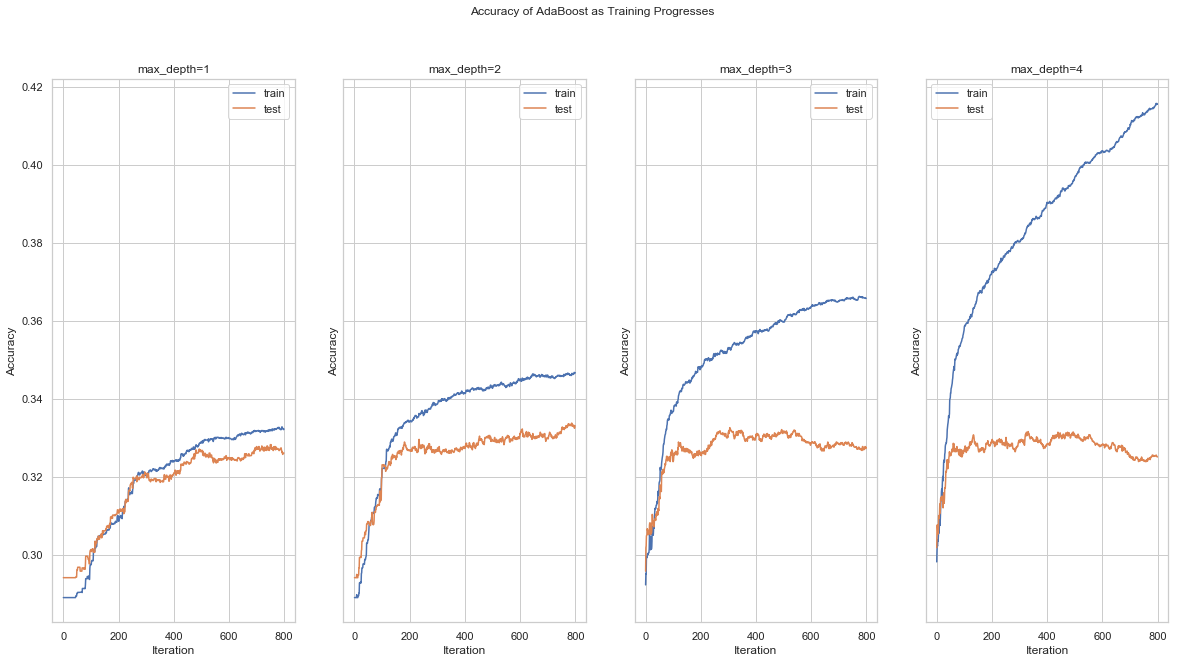

In [107]:
# your code here
clfs = {}
train_scores = {}
test_scores = {}
for depth in (1,2,3,4,5):
    fitted_ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        n_estimators=800,
        learning_rate=.05).fit(X_normalized, y_train)
    train_scores[depth] = list(fitted_ada.staged_score(X_normalized, y_train))
    test_scores[depth] = list(fitted_ada.staged_score(X_normalized_tst, y_test))
    clfs[depth] = fitted_ada
    
# your code here
fig, axs = plt.subplots(1, 4, figsize=(20,10), sharey=True)
for ax, depth in zip(axs, (1,2,3,4,5)):
    ax.plot(train_scores[depth], label='train')
    ax.plot(test_scores[depth], label='test')
    ax.set(xlabel='Iteration', ylabel='Accuracy', title=f"max_depth={depth}")
    ax.legend()
plt.suptitle("Accuracy of AdaBoost as Training Progresses");

In [108]:
# balanced data
# Let's first start with Logistic Model

logreg = LogisticRegression(random_state = 0, solver='lbfgs', multi_class='multinomial', max_iter = 1000)
logreg.fit(X_normalized, y_train)
y_pred = logreg.predict(X_normalized_tst)

mcm = multilabel_confusion_matrix(y_test, y_pred, sample_weight=None, labels=None, samplewise=False)
logreg.score(X_normalized_tst , y_test)

0.31465373034459687

In [152]:
logreg.score(X_normalized, y_train)

0.31787193107198125

In [153]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_normalized, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_normalized_tst, y_test) 
print(accuracy)

0.24406155904984944


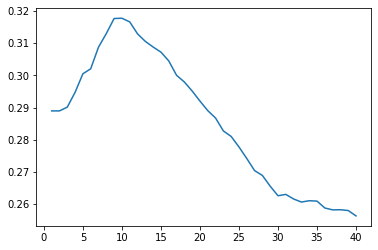

In [154]:
# decision tree with best depth by cv
depth_list = range(1,41)
score_list = []

for depth in depth_list:
#     print(depth)
    clf = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=depth)
    score = np.mean(cross_val_score(clf, X_normalized, y_train, cv=5))
    score_list.append(score)
plt.plot(depth_list, score_list)
plt.show()

In [155]:
best_depth = depth_list[np.argmax(score_list)]
best_depth

10

In [156]:
clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
clf.fit(X_normalized, y_train)
clf.score(X_normalized_tst, y_test)

0.32452325192372034

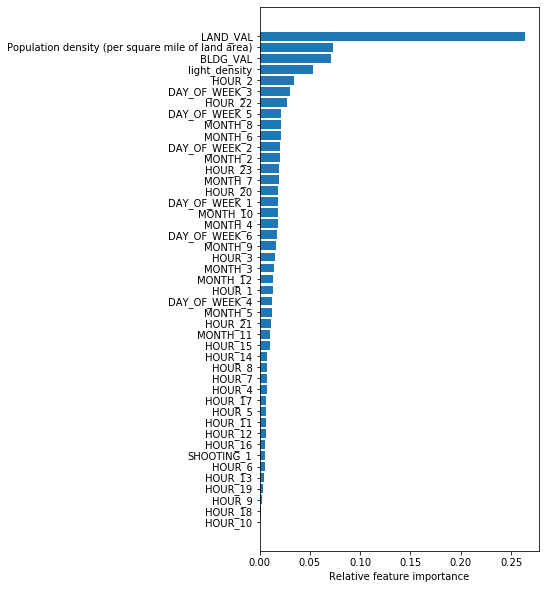

In [158]:
# plot feature importances
plt.figure(figsize=(5,10))
features = X_normalized.columns
feature_importances = clf.feature_importances_
idx = np.argsort(feature_importances)
plt.barh(y=features[idx], width=feature_importances[idx])
plt.xlabel("Relative feature importance")
plt.show()